In [16]:
import os
import shutil
import pickle
from itertools import product, chain
from multiprocessing import Pool, cpu_count

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from repelling import calculate_potential, make_solution
from collect_data import get_problem
from modcma.c_maes.cmaescpp.parameters import Solution

%matplotlib inline

data_folder = os.path.realpath("data")
ioh_logs = os.path.join(data_folder, "ioh")
pkl_logs = os.path.join(data_folder, "pkl")

def get_algorithm_name(coverage, strategy="RESTART", elitist=True, repelling=True):
    algorithm_name = f"CMA-ES-{strategy}"
    if repelling:
        algorithm_name += f"-repelling-c{coverage}"
    if elitist:
        algorithm_name += "-elitist"
    return algorithm_name


def get_pickles(fid, dim, strategy="RESTART", coverage=None, elitist=True):
    function = f"fid{fid}_dim{dim}.pkl"
    algorithm_name = get_algorithm_name(coverage, strategy, elitist, coverage > 0)
    query = f"{algorithm_name}_{function}"
    return [
        os.path.join(pkl_logs, f) 
        for f in os.listdir(pkl_logs) 
        if query in f
    ]

def load_pickle(file, fid, dim):
    with open(file, "rb") as f:
        data = pickle.load(f)

    potential = []
    for instance, run, centers in data:
        centers = [make_solution(*c) for c in centers]
        problem = get_problem(fid, instance, dim)
        pot, nd_runs = calculate_potential(centers, problem)
        potential.append(
            [fid, instance, problem.meta_data.n_variables, run, len(centers), nd_runs, 
            10_000 * problem.meta_data.n_variables, centers[-1].e, centers[-1].y - problem.optimum.y, pot
            ]
        )
    return pd.DataFrame(potential, columns=[
        "fid", "iid", "dim",  "run", "n_runs", "n_duplicate_runs", "budget", "evaluations", "delta_y", "potential"
    ])

def run_parallel_function(function, arguments):
    arguments = list(arguments)
    p = Pool(min(256, len(arguments)))
    results = p.map(function, arguments)
    p.close()
    return results


def load_file(x):
    strat, elit, fid, dim, coverage = x
    files = get_pickles(fid, dim, strat, coverage, elit)
    assert len(files) == 1
    df = load_pickle(files[0], fid, dim)
    df['alg'] = get_algorithm_name(coverage, strat, elit, coverage > 0)
    df['elitist'] = elit
    df['coverage'] = coverage
    df['strategy'] = strat
    return df

def get_data():
    if os.path.isfile("data/restart_data.pkl"):
        return pd.read_pickle("data/restart_data.pkl")
    data = []
    strats = ("RESTART", "IPOP", "BIPOP")
    elit = (True, False)
    bbob_fids = list(range(1, 25))
    cec_fids = list(range(1104, 1120))
    dims = (2, 3, 4, 5, 6, 7, 8, 9, 10, 20)
    coverage = (0., 2., 5., 10., 20., 50., 100., 200., 500., 1000.)
    bbob_parameters = product(strats, elit, bbob_fids, dims, coverage)
    cec_parameters = product(strats, elit, cec_fids, (1,), coverage)
    parameters = list(chain(bbob_parameters, cec_parameters))
    data = run_parallel_function(load_file, parameters)
    data['normalized_potential'] = data['potential'] / data['budget']
    data.to_pickle("data/restart_data.pkl")
    return pd.concat(data)


data = get_data()
data



,fid,iid,dim,run,n_runs,n_duplicate_runs,budget,evaluations,delta_y,potential,alg,elitist,coverage,strategy,normalized_potential
0,1,1,2,0,1,0,20000,175,6.115584e-09,0,CMA-ES-RESTART-elitist,True,0.0,RESTART,0.00000
1,1,1,2,1,1,0,20000,187,1.197448e-08,0,CMA-ES-RESTART-elitist,True,0.0,RESTART,0.00000
2,1,1,2,2,1,0,20000,181,1.512966e-08,0,CMA-ES-RESTART-elitist,True,0.0,RESTART,0.00000
3,1,1,2,3,1,0,20000,187,6.834000e-11,0,CMA-ES-RESTART-elitist,True,0.0,RESTART,0.00000
4,1,1,2,4,1,0,20000,163,1.237112e-09,0,CMA-ES-RESTART-elitist,True,0.0,RESTART,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1119,10,10,45,5,0,100000,19676,8.562233e-10,0,CMA-ES-BIPOP-repelling-c1000.0,False,1000.0,BIPOP,0.00000
496,1119,10,10,46,2,0,100000,5922,3.648470e-09,0,CMA-ES-BIPOP-repelling-c1000.0,False,1000.0,BIPOP,0.00000
497,1119,10,10,47,18,3,100000,100022,1.527698e+00,34357,CMA-ES-BIPOP-repelling-c1000.0,False,1000.0,BIPOP,0.34357
498,1119,10,10,48,20,4,100000,100120,1.242865e+02,45372,CMA-ES-BIPOP-repelling-c1000.0,False,1000.0,BIPOP,0.45372


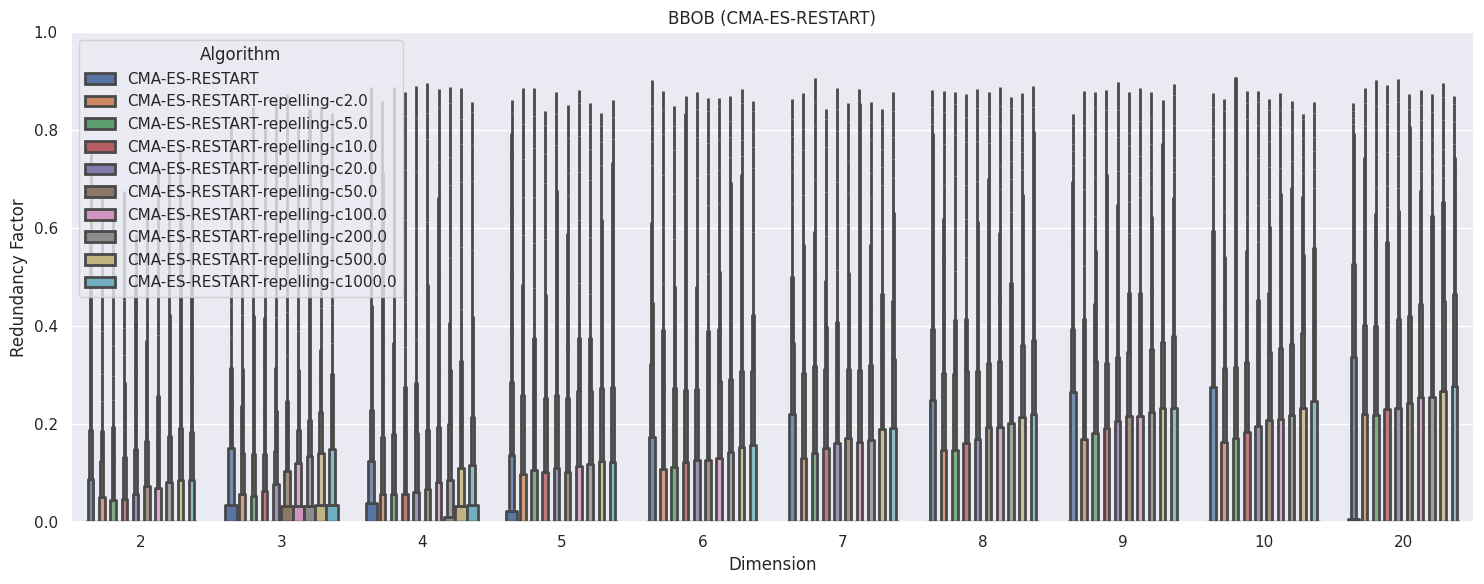

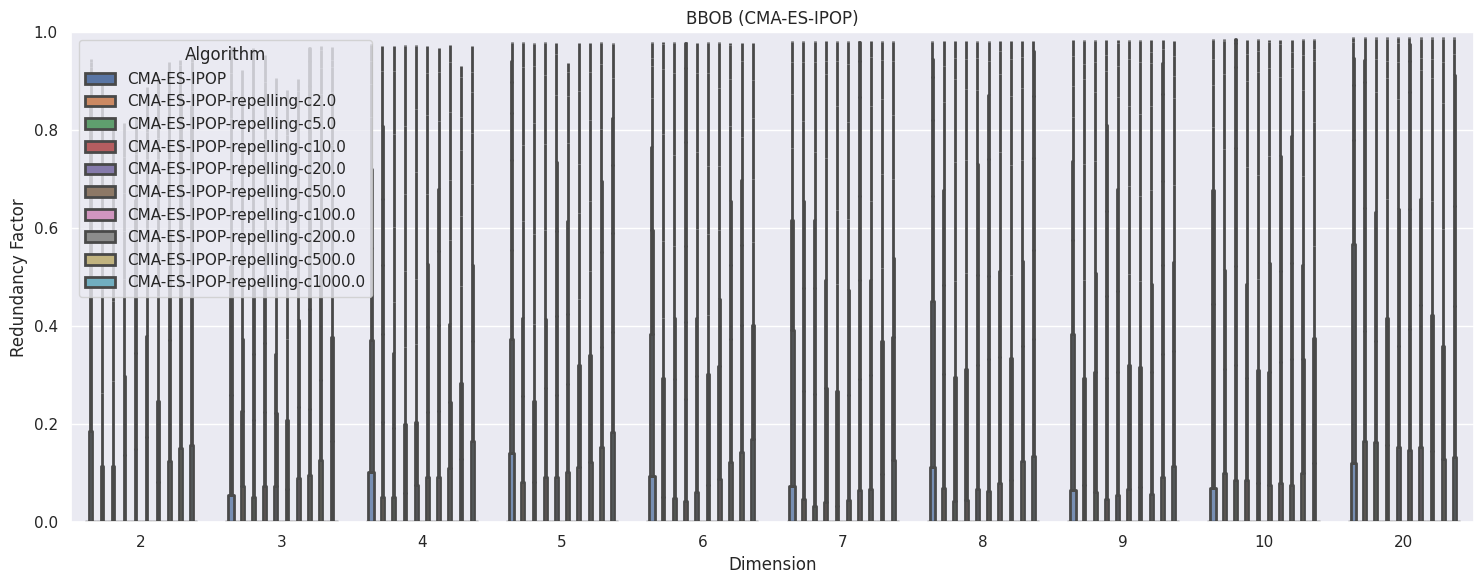

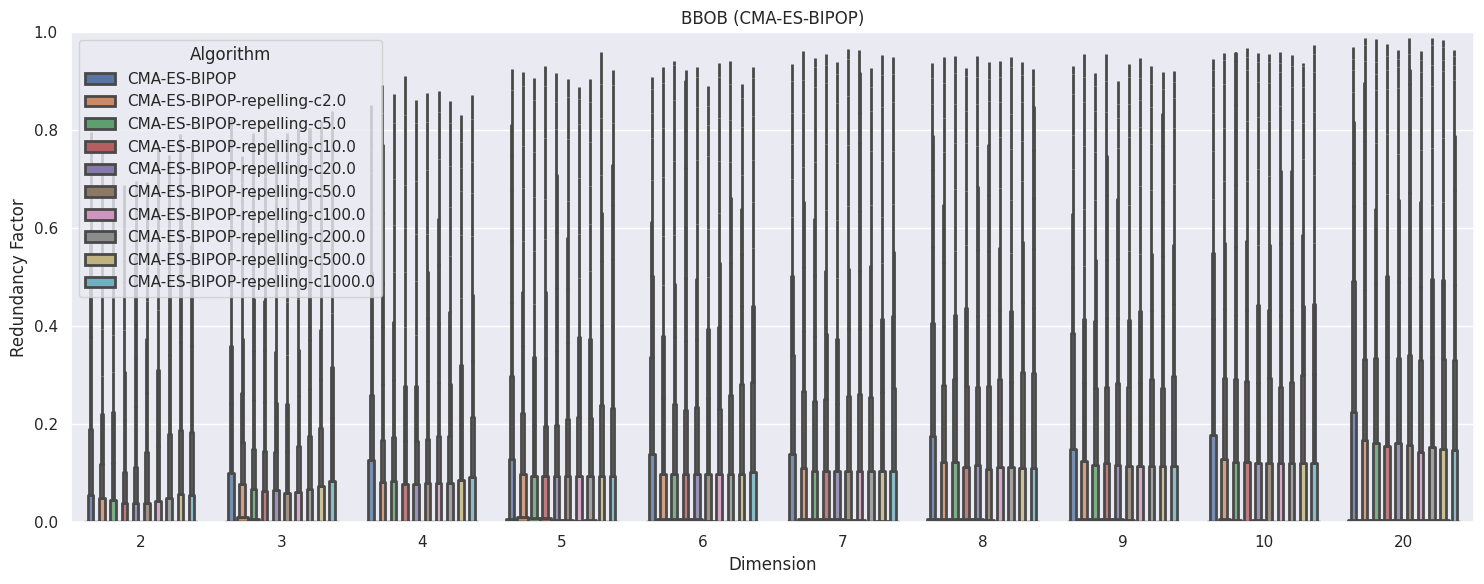

In [63]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10000 & fid < 200"),
        x="dim", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/bbob_potential_per_dim_{method}.pdf")

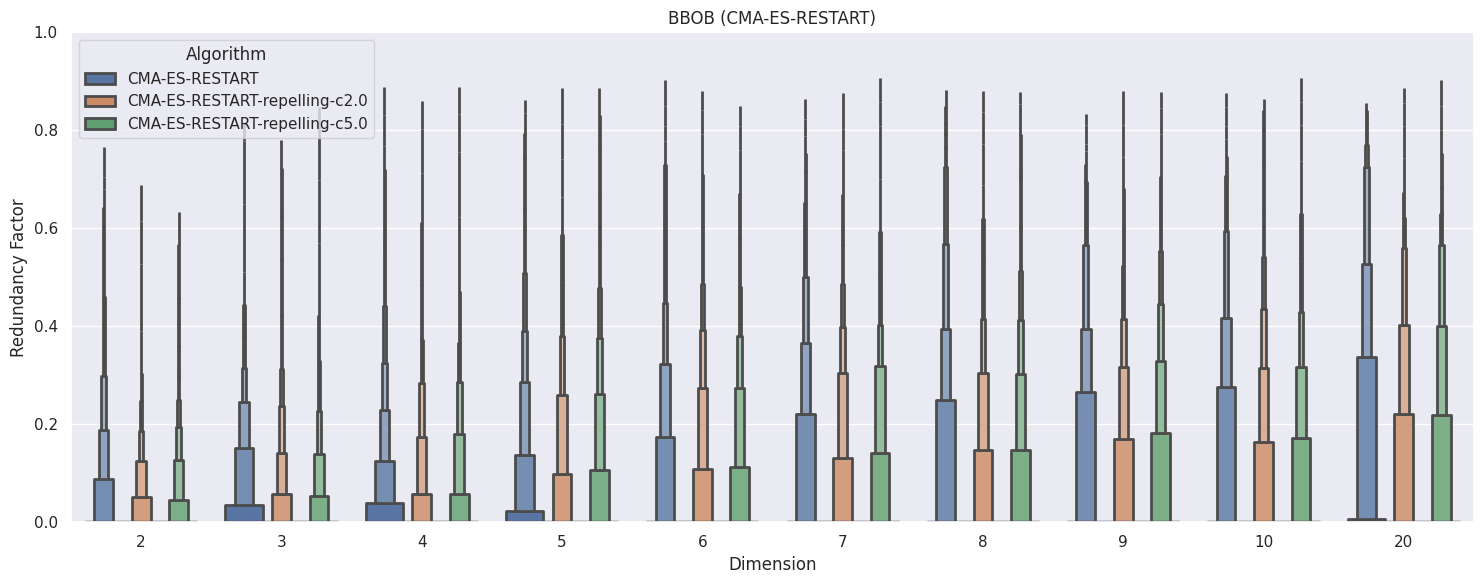

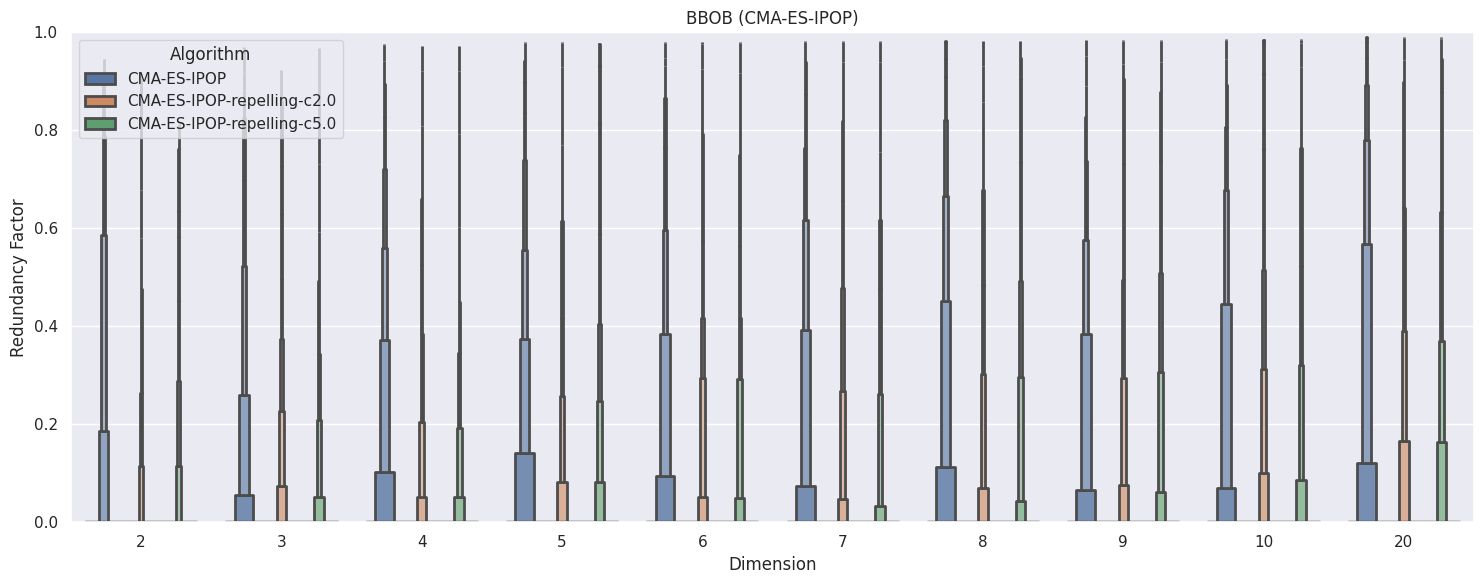

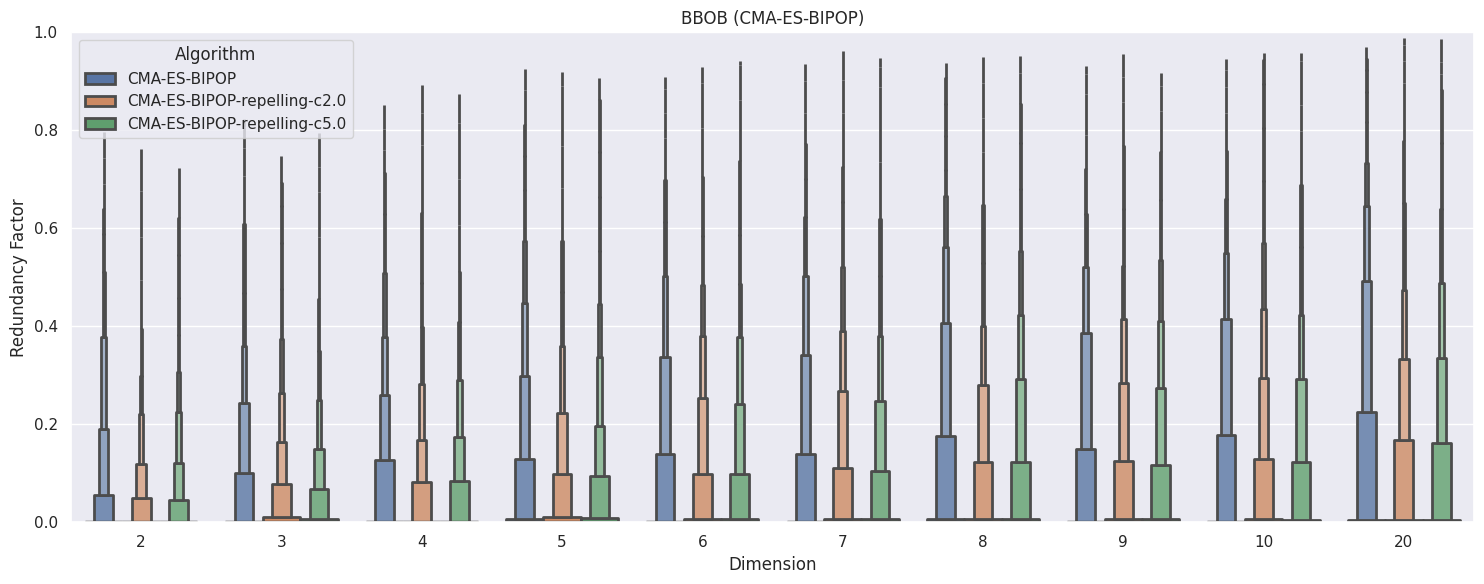

In [64]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10 & fid < 200"),
        x="dim", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/bbob_potential_per_dim_{method}_low_cov.pdf")

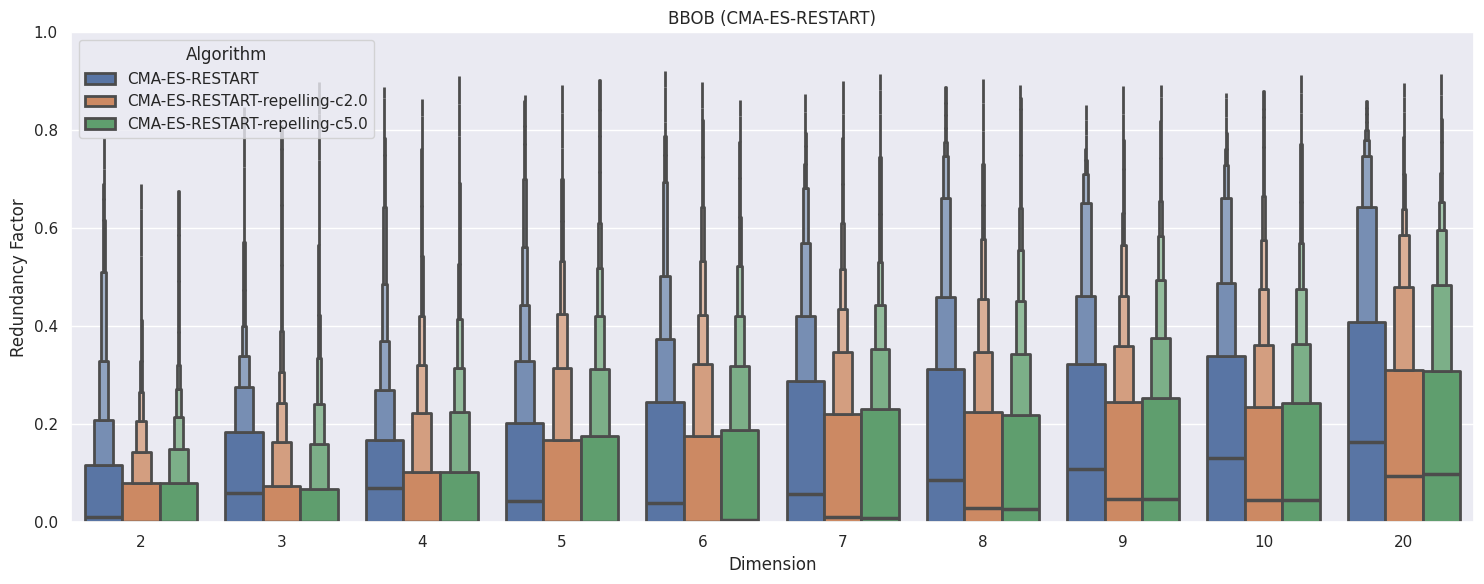

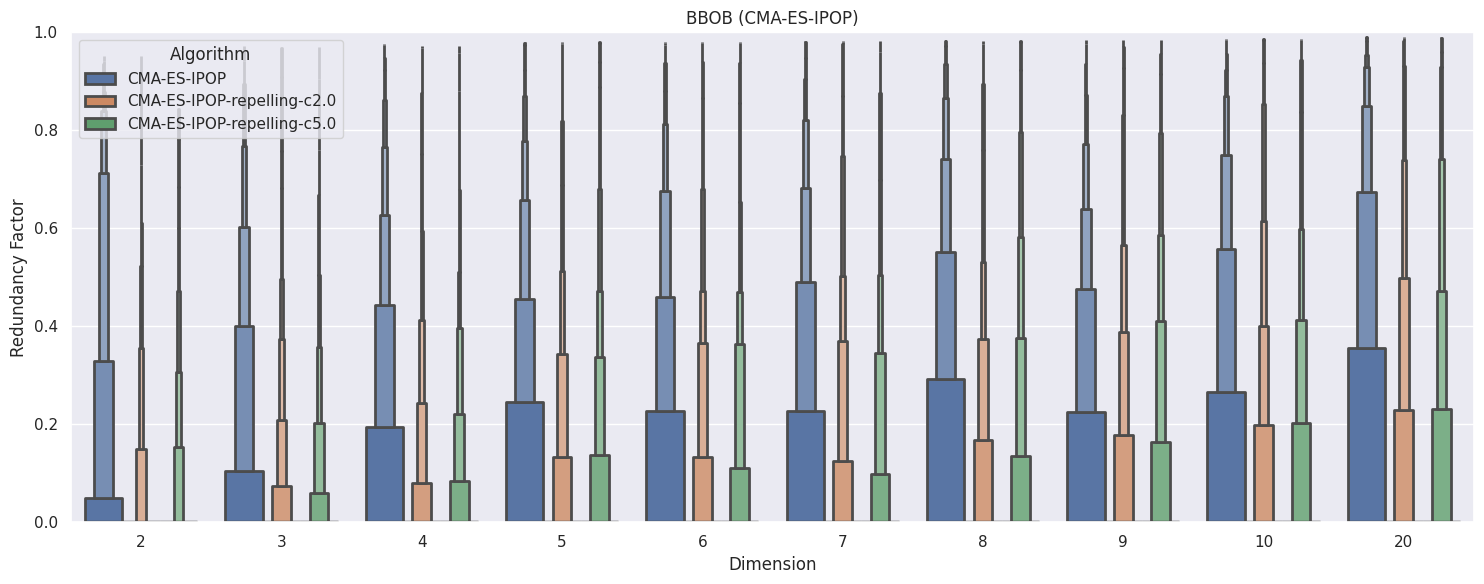

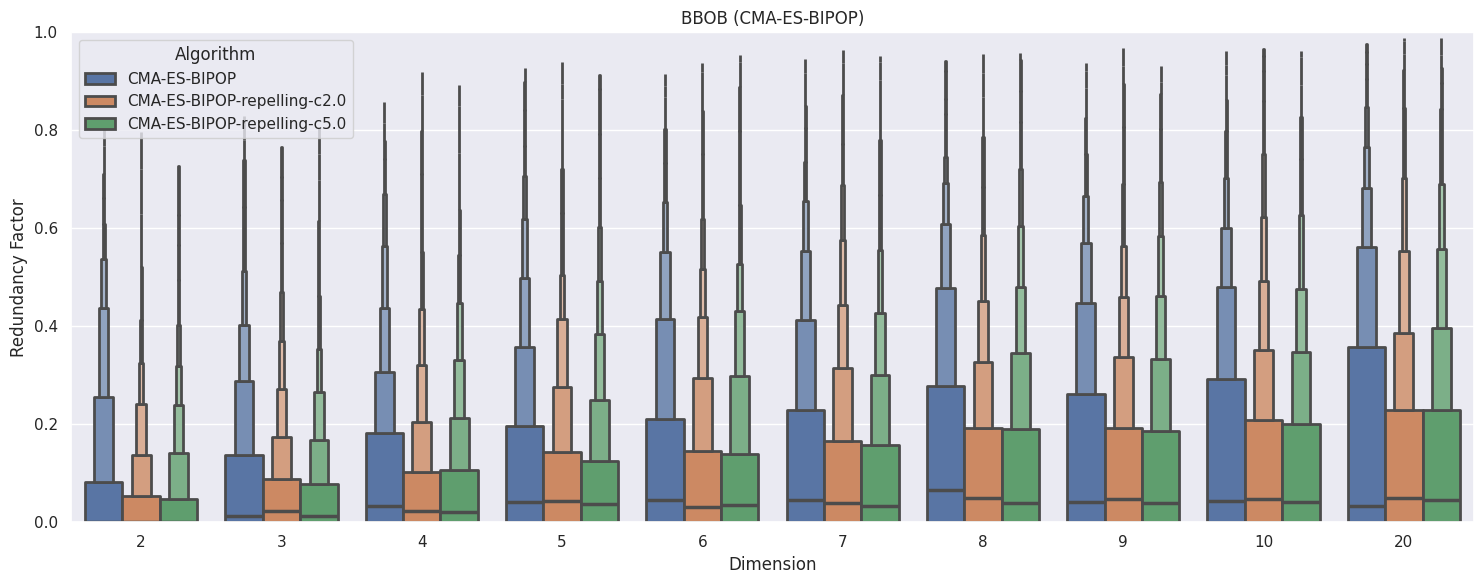

In [67]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10 & fid < 200 & fid in (3, 4, 7, 15, 19, 21, 22, 23, 24)"),
        x="dim", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/bbob_potential_per_dim_{method}_low_cov_fidpot.pdf")


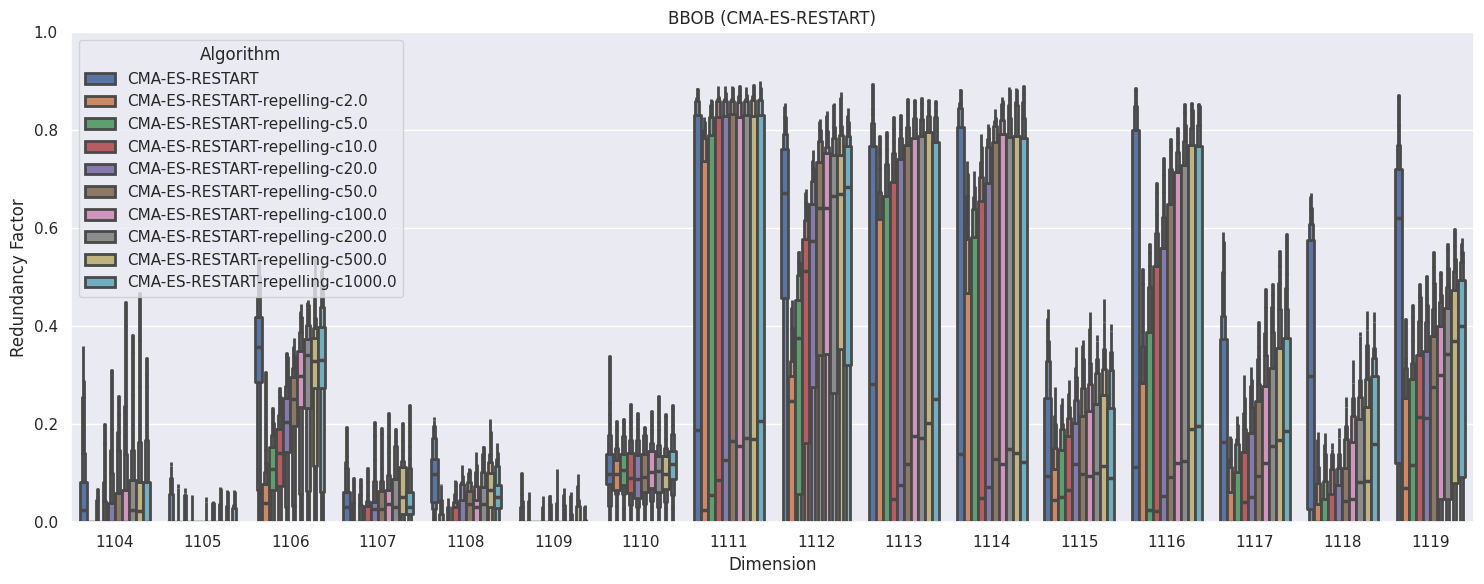

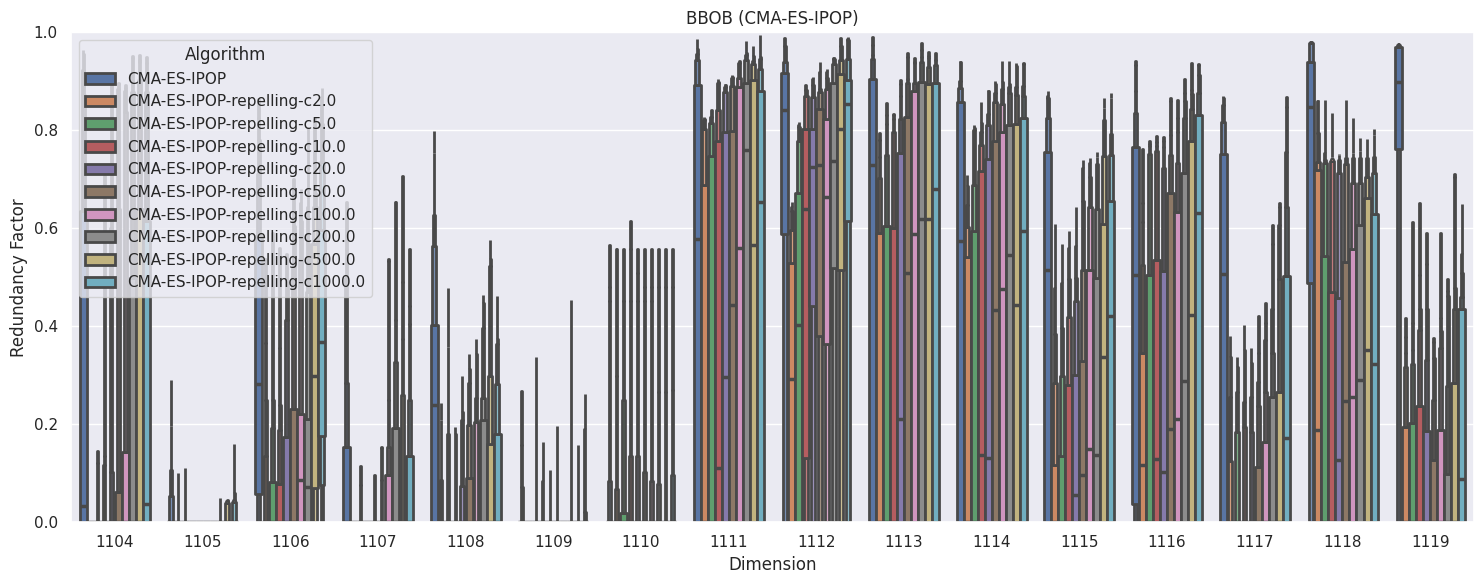

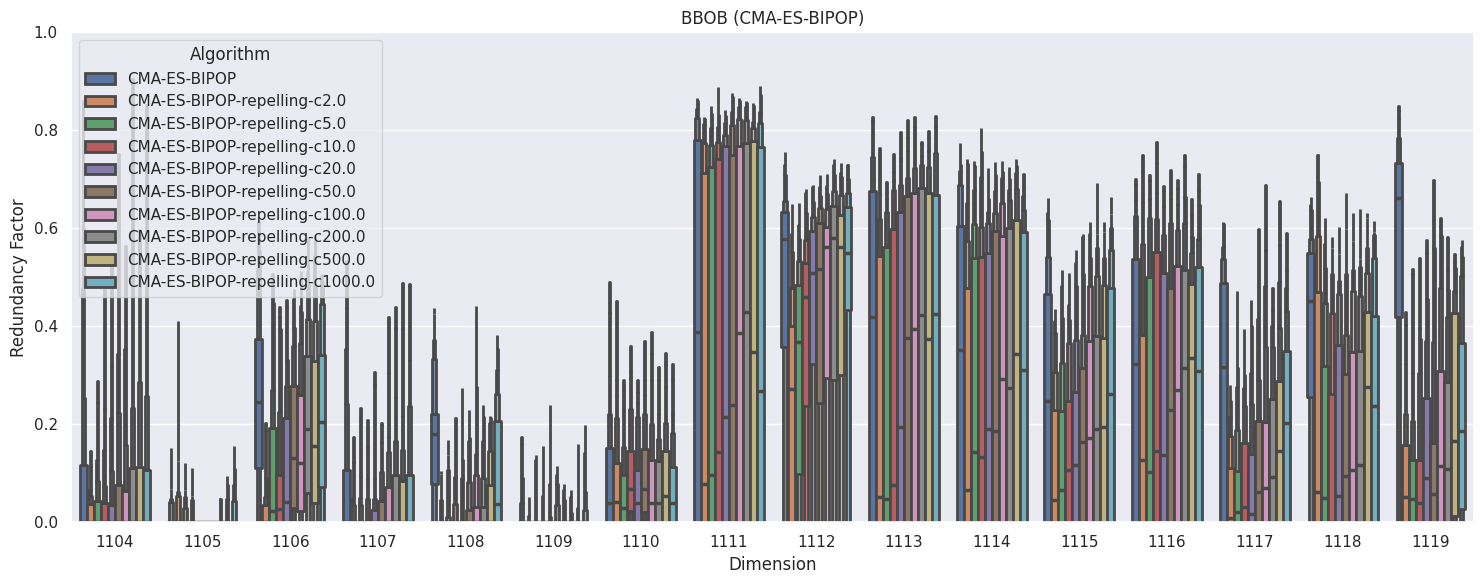

In [68]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10000 & fid > 200 "),
        x="fid", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/cec_potential_per_function.pdf")


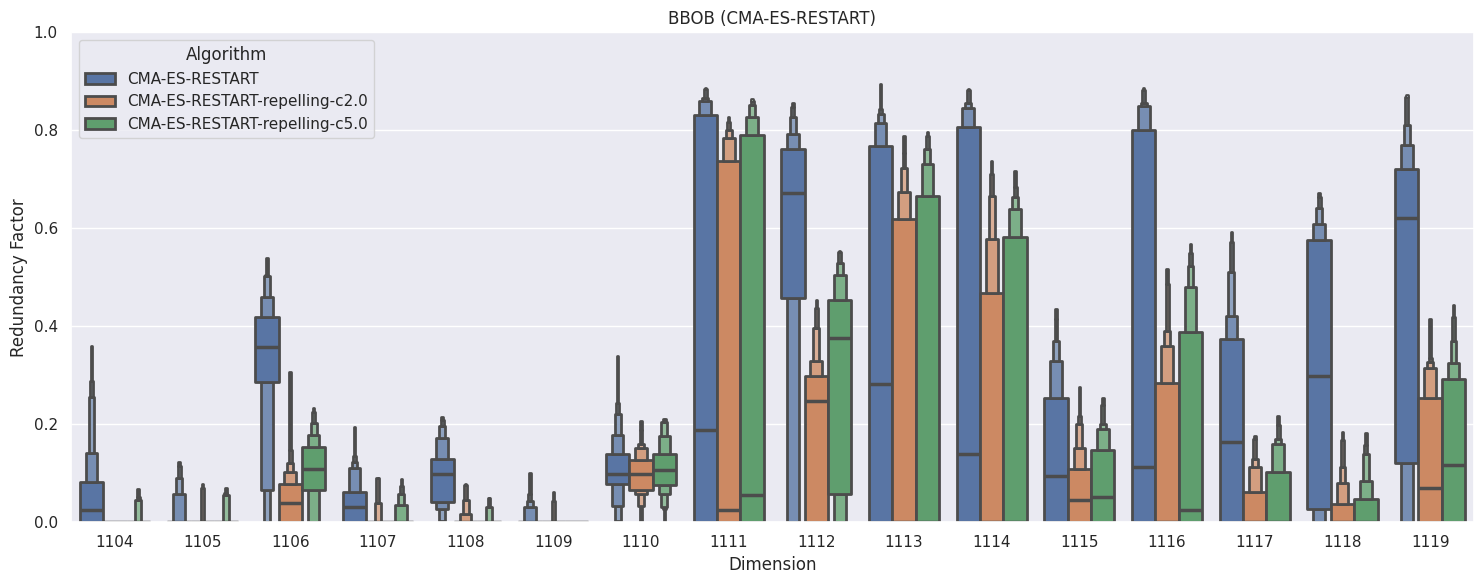

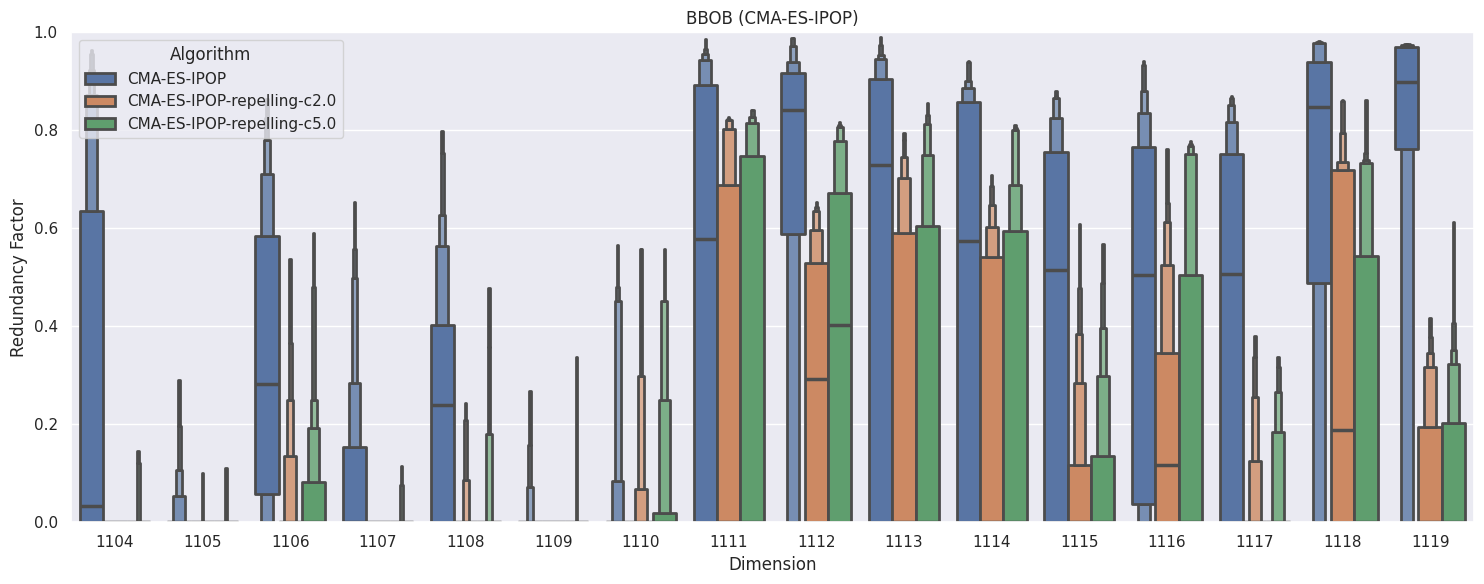

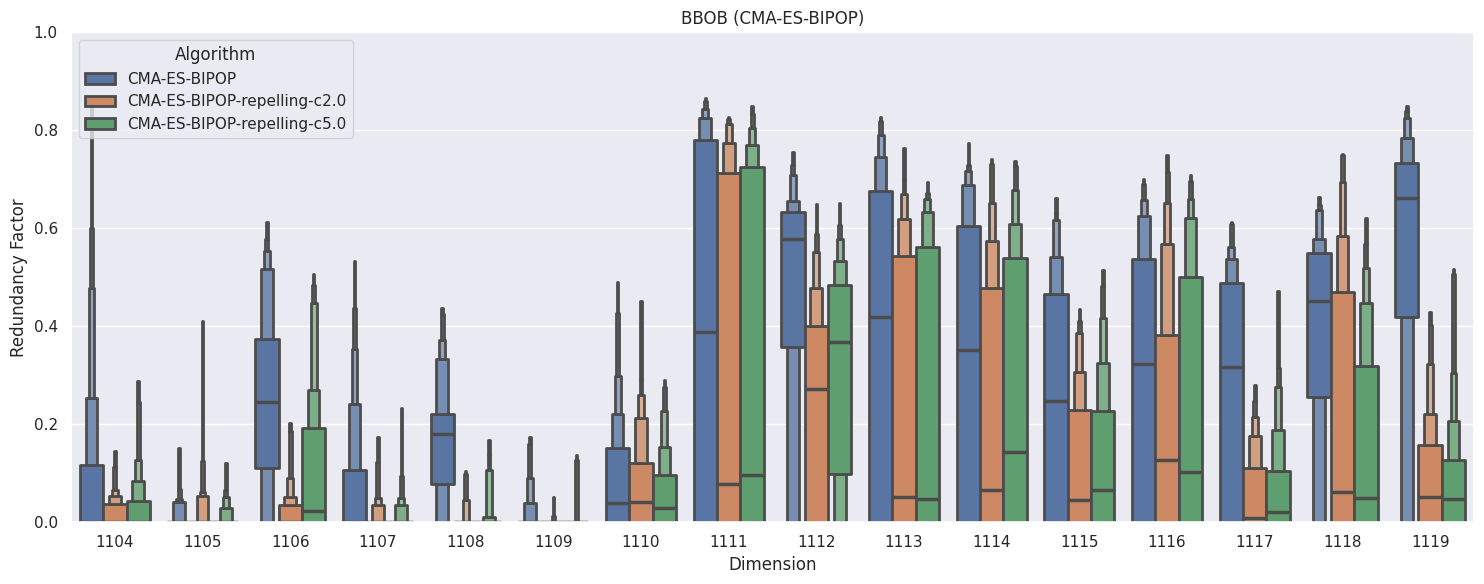

In [69]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10 & fid > 200"),
        x="fid", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/cec_potential_per_function_low_cov.pdf")

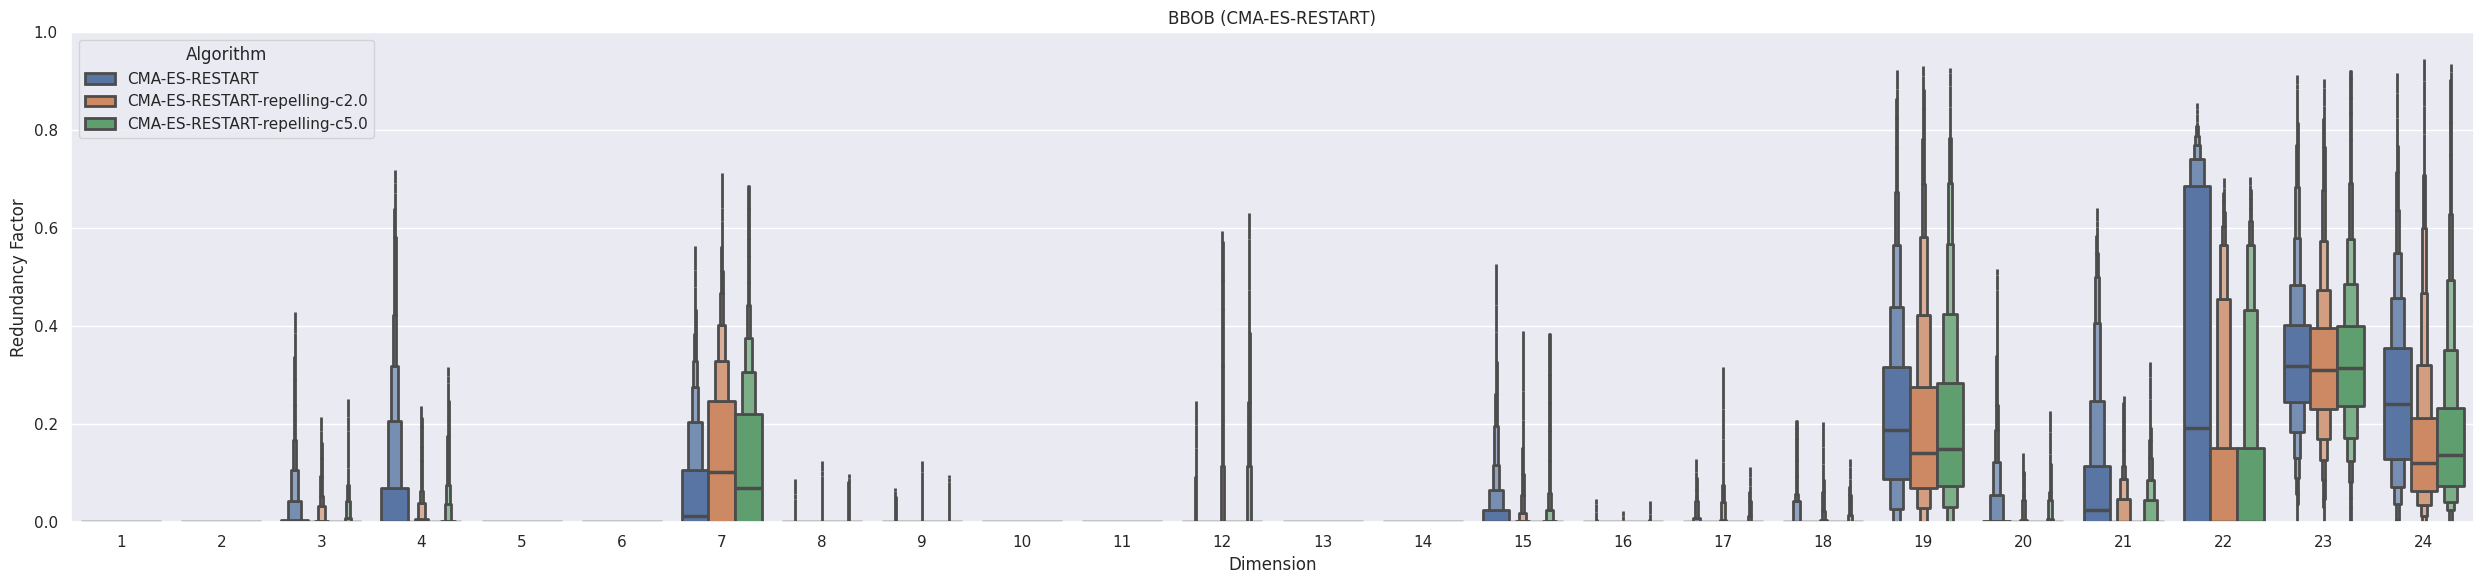

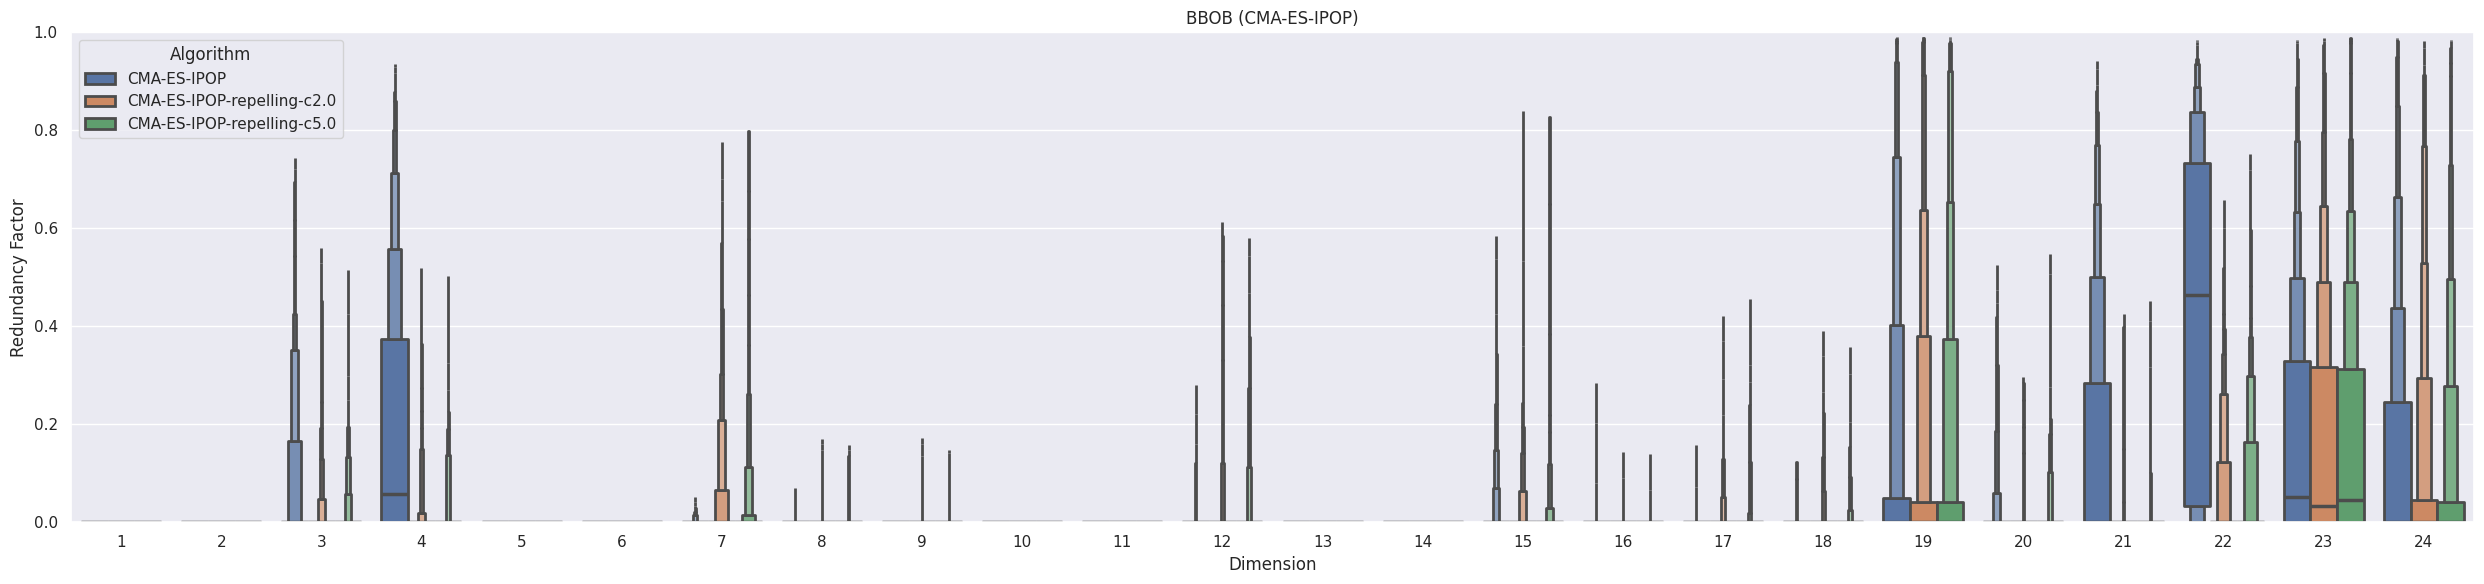

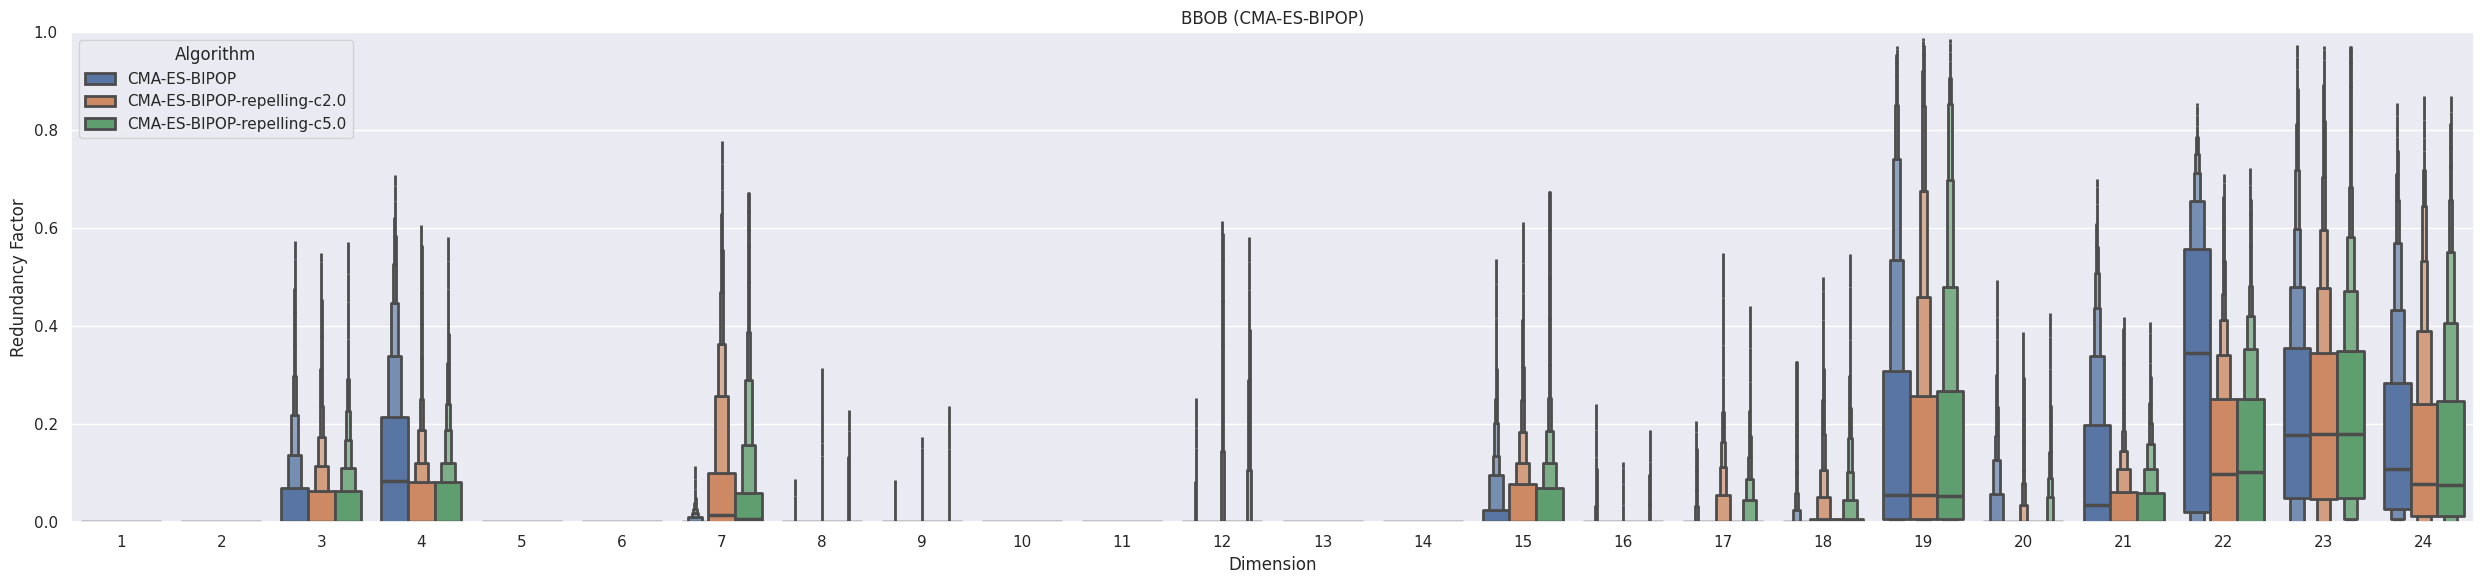

In [70]:
for method in ("RESTART", "IPOP", "BIPOP"):
    plt.figure(figsize=(25, 6))
    sns.set_theme(style="darkgrid")
    sns.boxenplot(
        data.query(f"elitist == False & strategy == '{method}' & coverage < 10 & fid < 200"),
        x="fid", 
        y="normalized_potential", 
        showfliers=False, 
        linewidth=2, 
        hue="alg"
    )
    plt.ylim(0, 1)
    plt.ylabel("Redundancy Factor")
    plt.xlabel("Dimension")
    plt.title(f"BBOB (CMA-ES-{method})")
    plt.tight_layout()
    plt.legend(loc='upper left', title="Algorithm")
    plt.savefig(f"figures/bbob_potential_per_function_low_cov.pdf")